In [10]:
import argparse
import csv
import numpy as np
import random
import string
import sys

### Helper functions ###
def generate_random_string(length, allowed_chars):
    return ''.join(random.choices(allowed_chars, k=length))


def generate_lengths(num_samples, mean_length, std_length, distribution,
                     allow_zero=False, min_length=1, max_length=100):
    if distribution == "normal":
        lengths = np.random.normal(mean_length, std_length, num_samples)
    elif distribution == "uniform":
        lengths = np.random.uniform(min_length, max_length, num_samples)
    elif distribution == "skewed":
        # Log Normal distribution
        sigma = std_length / mean_length
        mu = np.log(mean_length) + sigma**2
        lengths = np.random.lognormal(mean=mu, sigma=sigma, size=num_samples)
    else:
        raise ValueError(f"Unknown distribution type: {distribution}")


    # Round to the nearest integer.
    lengths = np.rint(lengths).astype(int)

    # Ensure lengths are at least min_length if allow_zero is False.
    if not allow_zero:
        lengths = np.maximum(lengths, min_length)

    # Clamp the lengths between min_length and max_length.
    lengths = np.clip(lengths, min_length, max_length)
    return lengths.tolist()


def generate_dataset(num_rows, num_cols, mean_length, std_length,
                     duplicate_factor=0.0, distribution="normal",
                     allowed_chars=string.ascii_letters + string.digits,
                     seed=None, min_length=1, max_length=100):
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)

    # Determine the number of unique rows.
    unique_count = max(1, int(num_rows * (1 - duplicate_factor)))
    duplicate_count = num_rows - unique_count

    unique_rows = []

    # Generate unique rows.
    for _ in range(unique_count):
        # For each cell in the row, generate a length then a random string.
        lengths = generate_lengths(
            num_cols, mean_length, std_length,
            distribution,allow_zero=False, min_length=min_length, 
            max_length=max_length
        )
        row = [generate_random_string(length, allowed_chars) for length in lengths]
        unique_rows.append(row)

    # For duplicate rows, randomly sample from the unique rows.
    duplicate_rows = [random.choice(unique_rows) for _ in range(duplicate_count)]

    # Combine and shuffle so that duplicates are not all grouped.
    all_rows = unique_rows + duplicate_rows
    random.shuffle(all_rows)
    return all_rows


def write_csv(filename, dataset, delimiter=","):
    with open(filename, "w", newline="") as csvfile:
        writer = csv.writer(csvfile, delimiter=delimiter)
        for row in dataset:
            writer.writerow(row)


In [19]:
import os

# Define parameter values
path = r"\\wsl.localhost\Ubuntu\home\tim\daphne_clean\daphne\experiments\datasets" # Path to save dataset to (./experiments/datasets/)
rows = 1000000
cols = 5
stds = [3]
duplicate_factors = [0.03, 0.5]
distributions = ["uniform"]
seeds = [1, 3]
length_ranges = [[1, 5, 10], [1, 500, 1000]]

# Ensure the output directory exists
os.makedirs(path, exist_ok=True)

# Loop over every combination of parameters
for s in stds:
    for dup in duplicate_factors:
        for dist in distributions:
            for seed in seeds:
                for min_length, mean, max_length in length_ranges:
                    # Construct a unique filename for the current combination
                    std_str = str(s).replace('.', '_')
                    filename = (
                        f"dataset_rows_{rows}_cols_{cols}_"
                        f"mean_{mean}_std_{std_str}_dup_{dup*100:.0f}_"
                        f"dist_{dist}_seed_{seed}_min_{min_length}_max_{max_length}.csv"
                    )
                    output = os.path.join(path, filename)
                    
                    # Generate the dataset for the current combination
                    dataset = generate_dataset(
                        num_rows=rows,
                        num_cols=cols,
                        mean_length=mean,
                        std_length=s,
                        duplicate_factor=dup,
                        distribution=dist,
                        seed=seed,
                        min_length=min_length,
                        max_length=max_length
                    )
                    
                    # Write the dataset to CSV
                    write_csv(output, dataset)
                    print(f"Dataset with {rows} rows and {cols} columns written to {output}")


Dataset with 1000000 rows and 5 columns written to \\wsl.localhost\Ubuntu\home\tim\daphne_clean\daphne\experiments\datasets\dataset_rows_1000000_cols_5_mean_5_std_3_dup_3_dist_uniform_seed_1_min_1_max_10.csv
Dataset with 1000000 rows and 5 columns written to \\wsl.localhost\Ubuntu\home\tim\daphne_clean\daphne\experiments\datasets\dataset_rows_1000000_cols_5_mean_500_std_3_dup_3_dist_uniform_seed_1_min_1_max_1000.csv
Dataset with 1000000 rows and 5 columns written to \\wsl.localhost\Ubuntu\home\tim\daphne_clean\daphne\experiments\datasets\dataset_rows_1000000_cols_5_mean_5_std_3_dup_3_dist_uniform_seed_3_min_1_max_10.csv
Dataset with 1000000 rows and 5 columns written to \\wsl.localhost\Ubuntu\home\tim\daphne_clean\daphne\experiments\datasets\dataset_rows_1000000_cols_5_mean_500_std_3_dup_3_dist_uniform_seed_3_min_1_max_1000.csv
Dataset with 1000000 rows and 5 columns written to \\wsl.localhost\Ubuntu\home\tim\daphne_clean\daphne\experiments\datasets\dataset_rows_1000000_cols_5_mean_5_s

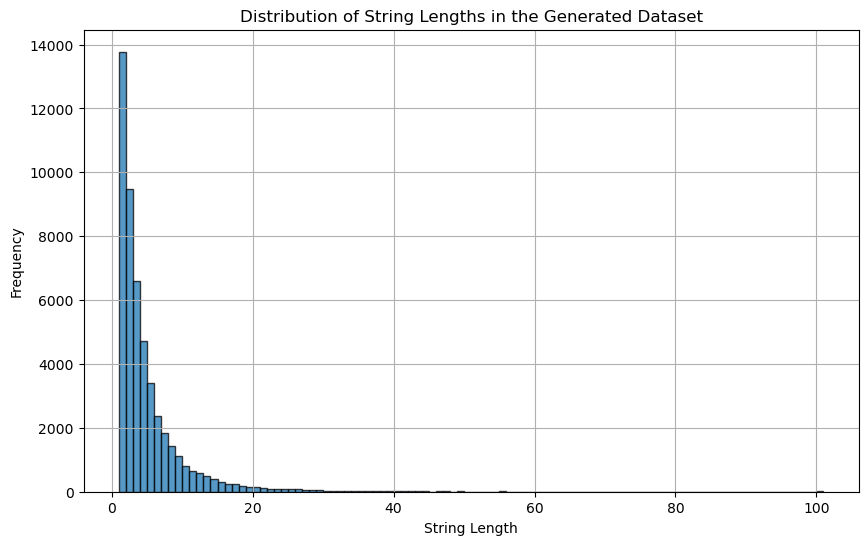

In [33]:
import matplotlib.pyplot as plt
# Parameters for dataset generation.
num_rows = 10000
num_cols = 5
mean_length = 1
std_length = 1
distribution = "skewed"
seed = 1
min_length=1
max_length=100


# Generate the dataset.
dataset = generate_dataset(num_rows, num_cols, mean_length, std_length,
                           distribution=distribution, seed=seed, min_length=min_length, max_length=max_length)

# Flatten all string lengths from the dataset.
all_lengths = [len(cell) for row in dataset for cell in row]

# Plot a histogram of the string lengths.
plt.figure(figsize=(10, 6))
# Setting bins from the minimum to the maximum length.
plt.hist(all_lengths, bins=range(min(all_lengths), max(all_lengths)+2), 
         edgecolor='black', alpha=0.75)
plt.title("Distribution of String Lengths in the Generated Dataset")
plt.xlabel("String Length")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [35]:
import os

# Define parameter values
path = r"\\wsl.localhost\Ubuntu\home\tim\daphne_clean\daphne\experiments\datasets" # Path to save dataset to (./experiments/datasets/)
rows = 1000000
cols = 5
stds = [1]
duplicate_factors = [0.0]
distributions = ["skewed"]
seeds = [1, 3]
length_ranges = [[1, 1, 100]]

# Ensure the output directory exists
os.makedirs(path, exist_ok=True)

# Loop over every combination of parameters
for s in stds:
    for dup in duplicate_factors:
        for dist in distributions:
            for seed in seeds:
                for min_length, mean, max_length in length_ranges:
                    # Construct a unique filename for the current combination
                    std_str = str(s).replace('.', '_')
                    filename = (
                        f"dataset_rows_{rows}_cols_{cols}_"
                        f"mean_{mean}_std_{std_str}_dup_{dup*100:.0f}_"
                        f"dist_{dist}_seed_{seed}_min_{min_length}_max_{max_length}.csv"
                    )
                    output = os.path.join(path, filename)
                    
                    # Generate the dataset for the current combination
                    dataset = generate_dataset(
                        num_rows=rows,
                        num_cols=cols,
                        mean_length=mean,
                        std_length=s,
                        duplicate_factor=dup,
                        distribution=dist,
                        seed=seed,
                        min_length=min_length,
                        max_length=max_length
                    )
                    
                    # Write the dataset to CSV
                    write_csv(output, dataset)
                    print(f"Dataset with {rows} rows and {cols} columns written to {output}")


Dataset with 1000000 rows and 5 columns written to \\wsl.localhost\Ubuntu\home\tim\daphne_clean\daphne\experiments\datasets\dataset_rows_1000000_cols_5_mean_1_std_1_dup_0_dist_skewed_seed_1_min_1_max_100.csv
Dataset with 1000000 rows and 5 columns written to \\wsl.localhost\Ubuntu\home\tim\daphne_clean\daphne\experiments\datasets\dataset_rows_1000000_cols_5_mean_1_std_1_dup_0_dist_skewed_seed_3_min_1_max_100.csv
